In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
import numpy as np  
from gcs import path_handler as ph
import gcs
import stream_analysis as sa

In [2]:
def extract_to_tail_coordinates(orbitpath,streampath,montecarlokey,internal_dynamics,NP):
    """
    Here to extract the raw data and transform the stream to tail coordinates in one go
    """

    time_of_interest,nDynTimes=0,2
    tOrb,xGCv,yGCv,zGCv,vxGCv,vyGCv,vzGCv = gcs.extractors.GCOrbits.extract_whole_orbit(orbitpath,montecarlokey=montecarlokey)
    tOrb,xGCv,yGCv,zGCv,vxGCv,vyGCv,vzGCv=sa.tailCoordinates.filter_orbit_by_dynamical_time(tOrb,xGCv,yGCv,zGCv,vxGCv,vyGCv,vzGCv,time_of_interest,nDynTimes)
    _,xp,yp,zp,vxp,vyp,vzp = gcs.extractors.Stream.extract_old_streams(streampath,internal_dynamics=internal_dynamics,montecarlokey=montecarlokey,NP=NP)
    xT,yT,zT,vxT,vyT,vzT,_ = sa.tailCoordinates.transform_from_galactico_centric_to_tail_coordinates(xp,yp,zp,vxp,vyp,vzp,tOrb,xGCv,yGCv,zGCv,vxGCv,vyGCv,vzGCv,t0=time_of_interest)
    return xT,yT,zT,vxT,vyT,vzT

In [3]:
GCname = "Pal5"
NP = int(1e5)
internal_dynamics = "isotropic-plummer"
montecarlokey="monte-carlo-009"
orbitPotential = "pouliasis2017pii-GCNBody"
streamPotential = "pouliasis2017pii-GCNBody"


In [5]:
orbitpath = ph.GC_orbits(MWpotential=orbitPotential,GCname=GCname)
streampath =ph.old_streams(MWpotential=streamPotential, GCname=GCname,montecarlokey=montecarlokey,NP=NP)
xT,yT,zT,vxT,vyT,vzT=extract_to_tail_coordinates(orbitpath,streampath,montecarlokey,internal_dynamics,NP)

In [6]:
XX,YY,H=sa.plotters.binned_density.short_cut(NP,xT,yT,[-10,10],[-1,1])
H=sa.plotters.binned_density.normalize_density_by_particle_number(H,NP)

In [16]:
cbarlabel=r"Density [$N_p/N$]"
normalScatterProperties = {
    "alpha":0.9, 
    "s":1,
    "cmap":'rainbow',
    "norm":colors.LogNorm(vmin=1e-5, vmax=1e-3)
    }
AXIS={
    "xlabel":"$x_{tail}$ [kpc]",
    "ylabel":"$y_{tail}$ [kpc]",
    "xlim":[-10,10],
    "ylim":[-0.5,0.5],
    "yticks": [0,0.5],
    "xticks": np.arange(-10,11,2),
    "yticks": np.arange(-0.4,0.5,0.2),
}


In [17]:
# Configure Matplotlib to use LaTeX for text rendering
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use 'serif' or specify the exact font family
    "font.serif": ["Times New Roman"],  # Replace with the font used in your LaTeX document
    "axes.labelsize": 12,  # Font size for axis labels
    "font.size": 12,  # General font size
    "legend.fontsize": 12,  # Font size for legend
    "xtick.labelsize": 12,  # Font size for x-axis tick labels
    "ytick.labelsize": 12,  # Font size for y-axis tick labels
})

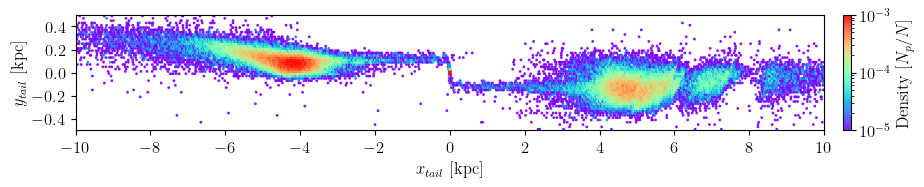

In [18]:
fig=plt.figure(figsize=(10,1.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 0.01],wspace=0.05)
cbar=fig.add_subplot(gs[1])
axis=fig.add_subplot(gs[0])
im = axis.scatter(XX,YY,c=H,**normalScatterProperties)
axis.set(**AXIS);
cbar = plt.colorbar(im, cax=cbar)
cbar.set_label(cbarlabel)